In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from pylab import rcParams
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC

from sklearn.tree import export_graphviz
import graphviz

import matplotlib.pyplot as plt
import seaborn as sb

from scipy.stats import uniform as sp_uniform
from scipy.stats import randint as sp_randint

## 1

### a

In [2]:
biden = pd.read_csv('biden.csv')

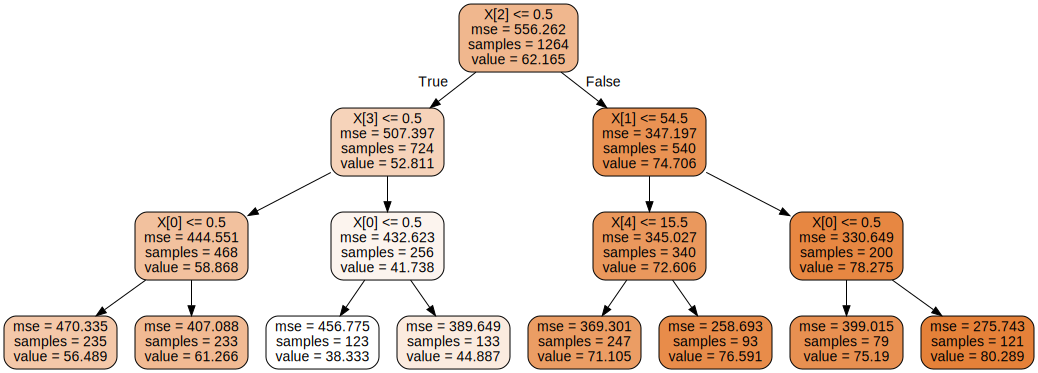

In [3]:
X = biden[['female','age','dem','rep','educ']]
y = biden['biden']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=25)
biden_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_train = biden_tree.fit(X_train,y_train)
biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    # feature_names=iris.feature_names[2:],
    # class_names=iris.target_names,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

The result shows the step of dividing. The first step is seperate $dem = 1$ and $dem = 0$. If $dem = 0$ then seperate $rep = 1$ and $rep = 0$, then in both cases seperate $female = 1$ and $female = 0$. If $dem = 1$ then seperate $age <= 54.5$ and $age > 54.5$, then if $age <= 54.5$ seperate $educ <= 15.5$ and $educ > 15.5$; if $age > 54.5$ seperate $female = 1$ and $female = 0$. As shown in the picture, the most accurate estimation is the type with $dem = 1,\ age <= 54.5,\ educ<=15.5$

In [4]:
y_pred = biden_tree.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
print('MSE=', MSE)

MSE= 396.1937146321307


The test MSE is $396.1937146321307$

### b

In [5]:
param_dist1 = {'max_depth': [3, 10],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20)}
random_tree = RandomizedSearchCV(DecisionTreeRegressor(), param_dist1, 
                                 n_iter=100, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')

In [6]:
biden_tree2 = random_tree.fit(X_train, y_train)
print('Optimal tuning parameter values are\n', biden_tree2.best_params_)
print('MSE of the optimal results is', abs(biden_tree2.best_score_))

Optimal tuning parameter values are
 {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 9}
MSE of the optimal results is 404.7488359884144


### c

In [7]:
param_dist2 = {'n_estimators': [10, 200],'max_depth': [3, 10],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20),
               'max_features': sp_randint(1, 5)}
random_forest = RandomizedSearchCV(RandomForestRegressor(), param_dist2, 
                                   n_iter=100, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')

In [8]:
biden_random_forest = random_forest.fit(X_train, y_train)
print('Optimal tuning parameter values are\n', biden_random_forest.best_params_)
print('MSE of the optimal results is', abs(biden_random_forest.best_score_))

Optimal tuning parameter values are
 {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 19, 'min_samples_split': 11, 'n_estimators': 200}
MSE of the optimal results is 397.7897870858486


C:\Users\ccb\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 2

### a

In [9]:
Auto = pd.read_csv('Auto.csv',na_values = "?")
Auto.dropna(inplace=True)
Median = Auto['mpg'].median()
Auto['mpg_high'] = 0
Auto.mpg_high[Auto['mpg']>=Median] = 1
Auto['orgn1'] = 0
Auto.orgn1[Auto['origin']==1] = 1
Auto['orgn2'] = 0
Auto.orgn2[Auto['origin']==2] = 1
X = Auto[['cylinders', 'displacement', 'horsepower', 'weight','acceleration', 'year', 'orgn1', 'orgn2']]
y = Auto['mpg_high']
Xvars = X.values
yvars = y.values

In [10]:
kf_log = KFold(n_splits=4, shuffle=True, random_state=25)
kf_log.get_n_splits(Xvars)
err_1 = np.zeros(4)
err_0 = np.zeros(4)
MSE_vec_kf = np.zeros(4)
k_ind = int(0)
for train_index, test_index in kf_log.split(Xvars):
    # print("TRAIN:", train_index, "TEST:", test_index)
    print('k index=', k_ind)
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    err_1_pred = ((y_test!=y_pred)&(y_test == 1)).sum()/(y_test == 1).sum()
    err_0_pred = ((y_test!=y_pred)&(y_test == 0)).sum()/(y_test == 0).sum()
    err_1[k_ind] = err_1_pred
    err_0[k_ind] = err_0_pred
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    print('error rate of mpg_high = 1 for test set', k_ind, ' is', err_1_pred)
    print('error rate of mpg_high = 0 for test set', k_ind, ' is', err_0_pred)
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
err_1_avg = err_1.mean()
err_0_avg = err_0.mean()
print('The estimate MSE loocv of the test =', MSE_kf)
print('error rate of mpg_high = 1 for the test is', err_1_avg)
print('error rate of mpg_high = 0 for the test is', err_0_avg)

k index= 0
MSE for test set 0  is 0.14285714285714285
error rate of mpg_high = 1 for test set 0  is 0.14545454545454545
error rate of mpg_high = 0 for test set 0  is 0.13953488372093023
k index= 1
MSE for test set 1  is 0.09183673469387756
error rate of mpg_high = 1 for test set 1  is 0.07317073170731707
error rate of mpg_high = 0 for test set 1  is 0.10526315789473684
k index= 2
MSE for test set 2  is 0.07142857142857142
error rate of mpg_high = 1 for test set 2  is 0.043478260869565216
error rate of mpg_high = 0 for test set 2  is 0.09615384615384616
k index= 3
MSE for test set 3  is 0.08163265306122448
error rate of mpg_high = 1 for test set 3  is 0.05555555555555555
error rate of mpg_high = 0 for test set 3  is 0.11363636363636363
The estimate MSE loocv of the test = 0.09693877551020408
error rate of mpg_high = 1 for the test is 0.07941477339674582
error rate of mpg_high = 0 for the test is 0.11364706285146922


So The estimate MSE loocv of the test is $0.09693877551020408$, the error rate of mpg_high = 1 for the test is $0.07941477339674582$, the error rate of mpg_high = 0 for the test is $0.11364706285146922$

### b

In [11]:
param_dist3 = {'n_estimators': [10, 200],
               'max_depth': [3, 8],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20),
               'max_features': sp_randint(1, 8)}
random_forest2 = RandomizedSearchCV(RandomForestClassifier(), param_dist3, 
                                    n_iter=100, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')

In [12]:
auto_random_forest = random_forest2.fit(Xvars, yvars)
print('Optimal tuning parameter values are\n', auto_random_forest.best_params_)
print('MSE of the optimal results is', abs(auto_random_forest.best_score_))

Optimal tuning parameter values are
 {'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 12, 'min_samples_split': 4, 'n_estimators': 10}
MSE of the optimal results is 0.08928571428571429


### c

In [13]:
param_dist4 = {'C': sp_uniform(loc=0.2, scale=4.0),
               'gamma': ['scale', 'auto'],
               'shrinking': [True, False]}
random_SVC = RandomizedSearchCV(SVC(kernel='rbf'), param_dist4, 
                                n_iter=100, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')

In [14]:
auto_random_SVC = random_SVC.fit(Xvars, yvars)
print('Optimal tuning parameter values are\n', auto_random_SVC.best_params_)
print('MSE of the optimal results is', abs(auto_random_SVC.best_score_))

Optimal tuning parameter values are
 {'C': 1.8094629152568114, 'gamma': 'scale', 'shrinking': False}
MSE of the optimal results is 0.11479591836734694


### d

Judge from the MSE, I think the best predictor of mpg_high is Random Forest Classifier because the MSE of the model is the smallest.